# **Import Library**

In [4]:
!pip install -U noisereduce --quiet

In [6]:
# Common
import os
import gdown
import random
import librosa
import numpy as np
import soundfile as sf
import tensorflow as tf
import noisereduce as nr
import IPython.display as ipd
import matplotlib.pyplot as plt

# Datasets
from datasets import Audio, Dataset, ClassLabel, concatenate_datasets, load_from_disk
from collections import Counter, defaultdict

# Modelling
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from tensorflow.keras import models, layers, callbacks
from sklearn.utils.class_weight import compute_class_weight

In [7]:
# Secret
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
BirdSet_RAW_URL = user_secrets.get_secret("BirdSet_RAW_URL")
BirdSet_10_16Khz_URL = user_secrets.get_secret("BirdSet_10_16Khz_URL")
BirdSet_10_16Khz_Features_URL = user_secrets.get_secret("BirdSet_10_16Khz_Features_URL")
BirdSet_10_16Khz_Augmented_URL = user_secrets.get_secret("BirdSet_10_16Khz_Augmented_URL")

# **Load Dataset**

In [ ]:
gdown.download_folder(BirdSet_RAW_URL, output="../temp/BirdSet_RAW", quiet=True)

In [ ]:
dataset = load_from_disk("../temp/BirdSet_RAW")
dataset

In [ ]:
train_ds = dataset["train"]
train_ds

# **Exploratory Data Analysis**

In [ ]:
ebird_code_names = train_ds.features["ebird_code"].names
ebird_code_names

In [ ]:
label_counter = Counter()

# Hitung berdasarkan ebird_code sebagai key
def count_label_ids(example):
    label_id = example["ebird_code"]
    label_counter.update([label_id])

train_ds.map(count_label_ids)

# Menampilkan label top 10 kelas
for label_id, count in label_counter.most_common(10):
    label_name = ebird_code_names[label_id]
    print(f"{label_name}: {count}")

# **Preprocessing Dataset**

## **Select Top 10 Labels**

In [ ]:
gdown.download_folder(BirdSet_RAW_URL, output="../temp/BirdSet_RAW", quiet=True)

In [ ]:
dataset = load_from_disk("../temp/BirdSet_RAW")
dataset = dataset.cast_column("audio", Audio(sampling_rate=16_000))
dataset

In [ ]:
train_ds = dataset["train"]
train_ds

In [ ]:
top_10_labels = dict(label_counter.most_common(10))
train_ds = train_ds.filter(lambda x: x["ebird_code"] in top_10_labels)
train_ds

In [ ]:
# Buat mapping: label lama -> label baru (0-9)
ebird_code_names = train_ds.features["ebird_code"].names
ebird_codes = set(train_ds["ebird_code"])
label2idx = {label: idx for idx, label in enumerate(ebird_codes)}

def remap_labels(example):
    example["ebird_code"] = label2idx[example["ebird_code"]]
    return example

# Terapkan ke seluruh dataset
train_ds = train_ds.map(remap_labels)

# Buat objek ClassLabel baru
new_class_label = ClassLabel(num_classes=len(ebird_codes), names=[ebird_code_names[ebird_code] for ebird_code in ebird_codes])

# Cast ulang kolom label agar metadata-nya ikut berubah
train_ds = train_ds.cast_column("ebird_code", new_class_label)

In [ ]:
train_ds.save_to_disk("../temp/BirdSet_10_16Khz", num_proc=os.cpu_count())

In [ ]:
!tar -czvf "./BirdSet_10_16Khz.tar.gz" "../temp/BirdSet_10_16Khz"

## **Event Based Audio**

In [ ]:
gdown.download_folder(BirdSet_10_16Khz_URL, output="../temp/BirdSet_10_16Khz", quiet=True)

In [8]:
!tar -xzvf BirdSet_10_16Khz.tar.gz -C ../

temp/BirdSet_10_16Khz/
temp/BirdSet_10_16Khz/state.json
temp/BirdSet_10_16Khz/data-00000-of-00005.arrow
temp/BirdSet_10_16Khz/data-00001-of-00005.arrow
temp/BirdSet_10_16Khz/data-00003-of-00005.arrow
temp/BirdSet_10_16Khz/dataset_info.json
temp/BirdSet_10_16Khz/data-00004-of-00005.arrow
temp/BirdSet_10_16Khz/data-00002-of-00005.arrow


In [11]:
train_ds = load_from_disk("../temp/BirdSet_10_16Khz")
train_ds

Dataset({
    features: ['audio', 'filepath', 'start_time', 'end_time', 'low_freq', 'high_freq', 'ebird_code', 'ebird_code_multilabel', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'detected_events', 'event_cluster', 'peaks', 'quality', 'recordist', 'genus', 'species_group', 'order', 'genus_multilabel', 'species_group_multilabel', 'order_multilabel'],
    num_rows: 3220
})

In [12]:
def cut_events(audio_array, sampling_rate, detected_events, min_len, max_len):
    total_duration = len(audio_array) / sampling_rate
    segments = []
    
    for start, end in detected_events:
        event_duration = end - start

        if event_duration < min_len:
            extension = (min_len - event_duration) / 2
            start = max(0, start - extension)
            end = min(total_duration, end + extension)

        if end - start > max_len:
            end = start + max_len

        start_idx = int(start * sampling_rate)
        end_idx = int(end * sampling_rate)
        segment = audio_array[start_idx:end_idx]
        segments.append(segment)

    if segments:
        return np.concatenate(segments)
    else:
        return audio_array  # fallback kalau kosong


def cut_time_range(audio_array, sampling_rate, start, end):
    start_idx = int(start * sampling_rate)
    end_idx = int(end * sampling_rate)

    return audio_array[start_idx:end_idx]


def denoise_audio(audio_array, sampling_rate):
    return nr.reduce_noise(y=audio_array, sr=sampling_rate)


def pad_or_trim(audio_array, sampling_rate, max_len):
    desired_len = int(max_len * sampling_rate)
    current_len = len(audio_array)

    if current_len < desired_len:
        pad_len = desired_len - current_len
        audio_array = np.pad(audio_array, (0, pad_len))
    else:
        audio_array = audio_array[:desired_len]

    return audio_array

def load_audio_all_events(sample, min_len, max_len):
    ebird_code = sample["ebird_code"]
    _, audio_array, sampling_rate = sample["audio"].values()

    # Potong berdasarkan event atau time range
    if len(sample["detected_events"]) > 0:
        audio_array = cut_events(audio_array, sampling_rate, sample["detected_events"], min_len, max_len)
    elif sample["start_time"] is not None and sample["end_time"] is not None:
        audio_array = cut_time_range(audio_array, sampling_rate, sample["start_time"], sample["end_time"])

    # Denoising + pad/trim
    audio_array = denoise_audio(audio_array, sampling_rate)
    audio_array = pad_or_trim(audio_array, sampling_rate, max_len)

    return {
        "ebird_code": ebird_code,
        "sampling_rate": sampling_rate,
        "features": audio_array
    }

In [13]:
feature_ds = train_ds.map(
    lambda x: load_audio_all_events(x, min_len=5, max_len=5),
    remove_columns=train_ds.column_names,
    desc="Select Audio by Event..."
)
feature_ds

Select Audio by Event...:   0%|          | 0/3220 [00:00<?, ? examples/s]

Dataset({
    features: ['ebird_code', 'sampling_rate', 'features'],
    num_rows: 3220
})

In [14]:
feature_ds.save_to_disk("../temp/BirdSet_10_16Khz_Features", num_proc=os.cpu_count())

Saving the dataset (0/5 shards):   0%|          | 0/3220 [00:00<?, ? examples/s]

In [15]:
!tar -czvf "./BirdSet_10_16Khz_Features.tar.gz" "../temp/BirdSet_10_16Khz_Features"

tar: Removing leading `../' from member names
../temp/BirdSet_10_16Khz_Features/
../temp/BirdSet_10_16Khz_Features/state.json
../temp/BirdSet_10_16Khz_Features/data-00000-of-00005.arrow
../temp/BirdSet_10_16Khz_Features/data-00001-of-00005.arrow
../temp/BirdSet_10_16Khz_Features/data-00003-of-00005.arrow
../temp/BirdSet_10_16Khz_Features/dataset_info.json
../temp/BirdSet_10_16Khz_Features/data-00004-of-00005.arrow
../temp/BirdSet_10_16Khz_Features/data-00002-of-00005.arrow


## **Augmentation (Sudah dikerjakan orang lain)**

In [ ]:
gdown.download_folder(BirdSet_10_16Khz_Features_URL, output="../temp/BirdSet_10_16Khz_Features", quiet=True)

In [16]:
!tar -xzvf BirdSet_10_16Khz_Features.tar.gz -C ../

temp/BirdSet_10_16Khz_Features/
temp/BirdSet_10_16Khz_Features/state.json
temp/BirdSet_10_16Khz_Features/data-00000-of-00005.arrow
temp/BirdSet_10_16Khz_Features/data-00001-of-00005.arrow
temp/BirdSet_10_16Khz_Features/data-00003-of-00005.arrow
temp/BirdSet_10_16Khz_Features/dataset_info.json
temp/BirdSet_10_16Khz_Features/data-00004-of-00005.arrow
temp/BirdSet_10_16Khz_Features/data-00002-of-00005.arrow


In [17]:
feature_ds = load_from_disk("../temp/BirdSet_10_16Khz_Features")
feature_ds

Dataset({
    features: ['ebird_code', 'sampling_rate', 'features'],
    num_rows: 3220
})

In [31]:
label_counter = Counter()

# Hitung berdasarkan ebird_code sebagai key
def count_label_ids(example):
    label_id = example["ebird_code"]
    label_counter.update([label_id])

feature_ds.map(count_label_ids)

ebird_code_names = feature_ds.features["ebird_code"].names

# Menampilkan label top 10 kelas
for label_id, count in label_counter.most_common(10):
    label_name = ebird_code_names[label_id]
    print(f"{label_name} (id: {label_id}): {count}")

Map:   0%|          | 0/3220 [00:00<?, ? examples/s]

fepowl (id: 8): 373
ducfly (id: 1): 362
brratt1 (id: 2): 339
greant1 (id: 5): 331
butwoo1 (id: 9): 320
bubwre1 (id: 6): 311
bobfly1 (id: 0): 307
squcuc1 (id: 4): 300
oliwoo1 (id: 7): 298
barant1 (id: 3): 279


In [ ]:
# # === Fungsi augmentasi berbasis librosa ===
# # Menambahkan noise acak
# def add_noise(audio_array, noise_factor=0.005):
#     noise = np.random.randn(len(audio_array))
#     return audio_array + noise_factor * noise

# # Menggeser amplitudo (volume)
# def change_volume(audio_array, gain_db_range=(-6, 6)):
#     gain = np.random.uniform(*gain_db_range)
#     factor = 10.0 ** (gain / 20.0)
#     return audio_array * factor

# # Mengubah pitch tanpa mengubah panjang
# def apply_pitch_shift(audio_array, sampling_rate, steps_range=(-2, 2)):
#     n_steps = np.random.uniform(*steps_range)
#     return librosa.effects.pitch_shift(y=np.array(audio_array), sr=sampling_rate, n_steps=n_steps)

# # Inversi sinyal
# def invert_waveform(audio_array):
#     return -audio_array

# # Kliping sinyal
# def clip_audio(audio_array, clip_factor=0.8):
#     max_val = np.max(np.abs(audio_array)) * clip_factor
#     return np.clip(audio_array, -max_val, max_val)

# # Fungsi augmentasi satu sample
# def safe_augment_sample(example):
#     _, sampling_rate, features = example.values()

#     if random.random() < 0.5:
#         features = add_noise(features)

#     if random.random() < 0.5:
#         features = change_volume(features)

#     if random.random() < 0.5:
#         features = apply_pitch_shift(features, sampling_rate)

#     if random.random() < 0.3:
#         features = invert_waveform(features)

#     if random.random() < 0.3:
#         features = clip_audio(features)

#     example["features"] = features
#     return example

# # Hitung distribusi awal
# def get_class_counts(ds):
#     return Counter(ds["ebird_code"])

# # Mulai proses augmentasi sampai seimbang
# def balance_dataset(dataset, target_per_class):
#     all_augmented = []

#     class_counts = get_class_counts(dataset)
#     label_info = dataset.features["ebird_code"]
#     under_classes = [cls for cls, count in class_counts.items() if count < target_per_class]

#     for cls in under_classes:
#         # Ambil semua sampel dari kelas ini
#         samples = dataset.filter(lambda x: x["ebird_code"] == cls)
#         current_count = len(samples)
#         needed = target_per_class - current_count

#         augmented_examples = []

#         while len(augmented_examples) < needed:
#             sample = samples[random.randint(0, current_count - 1)]
#             augmented = augment_sample(sample)

#             augmented_examples.append(augmented)

#         # Batasi hanya sampai `needed`
#         augmented_dataset = Dataset.from_list(augmented_examples[:needed])
#         augmented_dataset = augmented_dataset.cast_column("ebird_code", label_info)
#         all_augmented.append(augmented_dataset)

#         print(f"Augmented {cls} from {current_count} → {target_per_class} samples.")

#     # Gabungkan semua augmented dengan original dataset
#     if all_augmented:
#         dataset = concatenate_datasets([dataset] + all_augmented)

#     return dataset

In [ ]:
# balanced_ds = balance_dataset(feature_ds, target_per_class=500)
# balanced_ds

In [ ]:
# label_counter = Counter()

# # Hitung berdasarkan ebird_code sebagai key
# def count_label_ids(example):
#     label_id = example["ebird_code"]
#     label_counter.update([label_id])

# balanced_ds.map(count_label_ids)

# ebird_code_names = balanced_ds.features["ebird_code"].names

# # Menampilkan label top 10 kelas
# for label_id, count in label_counter.most_common(10):
#     label_name = ebird_code_names[label_id]
#     print(f"{label_name} (id: {label_id}): {count}")

In [ ]:
# balanced_ds.save_to_disk("../temp/BirdSet_10_16Khz_Balanced", num_proc=os.cpu_count())

In [ ]:
# !tar -czvf "./BirdSet_10_16Khz_Balanced.tar.gz" "../temp/BirdSet_10_16Khz_Balanced"

# **Extracting Features**

In [5]:
gdown.download_folder(BirdSet_10_16Khz_Augmented_URL, output="../temp/BirdSet_10_16Khz_Augmented", quiet=True)

['../temp/BirdSet_10_16Khz_Augmented/data-00000-of-00005.arrow',
 '../temp/BirdSet_10_16Khz_Augmented/data-00001-of-00005.arrow',
 '../temp/BirdSet_10_16Khz_Augmented/data-00002-of-00005.arrow',
 '../temp/BirdSet_10_16Khz_Augmented/data-00003-of-00005.arrow',
 '../temp/BirdSet_10_16Khz_Augmented/data-00004-of-00005.arrow',
 '../temp/BirdSet_10_16Khz_Augmented/state.json',
 '../temp/BirdSet_10_16Khz_Augmented/dataset_info.json']

In [32]:
!tar -xzvf BirdSet_10_16Khz_Augmented.tar.gz -C ../

temp/BirdSet_10_16Khz_Augmented/
temp/BirdSet_10_16Khz_Augmented/state.json
temp/BirdSet_10_16Khz_Augmented/data-00000-of-00005.arrow
temp/BirdSet_10_16Khz_Augmented/data-00001-of-00005.arrow
temp/BirdSet_10_16Khz_Augmented/data-00003-of-00005.arrow
temp/BirdSet_10_16Khz_Augmented/dataset_info.json
temp/BirdSet_10_16Khz_Augmented/data-00004-of-00005.arrow
temp/BirdSet_10_16Khz_Augmented/data-00002-of-00005.arrow


In [33]:
augmented_ds = load_from_disk("../temp/BirdSet_10_16Khz_Augmented")
augmented_ds

Dataset({
    features: ['features', 'sampling_rate', 'ebird_code'],
    num_rows: 6440
})

In [34]:
def to_melspectrogram(sample):
    ebird_code = sample["ebird_code"]
    sampling_rate = sample["sampling_rate"]
    audio_array = np.array(sample["features"])

    mel_spec = librosa.feature.melspectrogram(y=audio_array, sr=sampling_rate, n_mels=40)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    return {
        "ebird_code": ebird_code,
        "sampling_rate": sampling_rate,
        "features": mel_spec_db
    }

def to_mfcc(sample):
    ebird_code = sample["ebird_code"]
    sampling_rate = sample["sampling_rate"]
    audio_array = np.array(sample["features"])
    
    mfcc = librosa.feature.mfcc(y=audio_array, sr=sampling_rate, n_mfcc=40)

    return {
        "ebird_code": ebird_code,
        "sampling_rate": sampling_rate,
        "features": mfcc
    }

## **Mel-Spectrogram Dataset**

In [36]:
melspectro_ds = augmented_ds.map(
    to_melspectrogram,
    remove_columns=augmented_ds.column_names,
    desc="Extracting Mel-Spectrogram Features..."
)
melspectro_ds

Extracting Mel-Spectrogram Features...:   0%|          | 0/6440 [00:00<?, ? examples/s]

Dataset({
    features: ['features', 'sampling_rate', 'ebird_code'],
    num_rows: 6440
})

In [37]:
melspectro_ds.save_to_disk("../temp/BirdSet_10_16Khz_Spectrogram", num_proc=os.cpu_count())

Saving the dataset (0/4 shards):   0%|          | 0/6440 [00:00<?, ? examples/s]

In [38]:
!tar -czvf "./BirdSet_10_16Khz_Spectrogram.tar.gz" "../temp/BirdSet_10_16Khz_Spectrogram"

tar: Removing leading `../' from member names
../temp/BirdSet_10_16Khz_Spectrogram/
../temp/BirdSet_10_16Khz_Spectrogram/data-00002-of-00004.arrow
../temp/BirdSet_10_16Khz_Spectrogram/data-00003-of-00004.arrow
../temp/BirdSet_10_16Khz_Spectrogram/state.json
../temp/BirdSet_10_16Khz_Spectrogram/data-00001-of-00004.arrow
../temp/BirdSet_10_16Khz_Spectrogram/data-00000-of-00004.arrow
../temp/BirdSet_10_16Khz_Spectrogram/dataset_info.json


## **MFCC Dataset**

In [39]:
mfcc_ds = augmented_ds.map(
    to_mfcc,
    remove_columns=augmented_ds.column_names,
    desc="Extracting MFCC Features..."
)
mfcc_ds

Extracting MFCC Features...:   0%|          | 0/6440 [00:00<?, ? examples/s]

Dataset({
    features: ['features', 'sampling_rate', 'ebird_code'],
    num_rows: 6440
})

In [40]:
mfcc_ds.save_to_disk("../temp/BirdSet_10_16Khz_MFCC", num_proc=os.cpu_count())

Saving the dataset (0/4 shards):   0%|          | 0/6440 [00:00<?, ? examples/s]

In [41]:
!tar -czvf "./BirdSet_10_16Khz_MFCC.tar.gz" "../temp/BirdSet_10_16Khz_MFCC"

tar: Removing leading `../' from member names
../temp/BirdSet_10_16Khz_MFCC/
../temp/BirdSet_10_16Khz_MFCC/data-00002-of-00004.arrow
../temp/BirdSet_10_16Khz_MFCC/data-00003-of-00004.arrow
../temp/BirdSet_10_16Khz_MFCC/state.json
../temp/BirdSet_10_16Khz_MFCC/data-00001-of-00004.arrow
../temp/BirdSet_10_16Khz_MFCC/data-00000-of-00004.arrow
../temp/BirdSet_10_16Khz_MFCC/dataset_info.json


# **Quality Check**

In [42]:
ipd.Audio(feature_ds[0]["features"], rate=16_000)

In [43]:
audio_data = librosa.feature.inverse.mel_to_audio(
    np.array(melspectro_ds[0]["features"]).squeeze(), sr=16_000
)

ipd.Audio(audio_data, rate=16_000)

In [44]:
audio_data = librosa.feature.inverse.mfcc_to_audio(
    np.array(mfcc_ds[1]["features"]).squeeze(), sr=16_000
)

ipd.Audio(audio_data, rate=16_000)

# **Modeling (Mel-Spectrogram)**

In [ ]:
gdown.download_folder("", output="../temp/BirdSet_10_16Khz_Spectrogram", quiet=True)

In [45]:
!tar -xzvf BirdSet_10_16Khz_Spectrogram.tar.gz -C ../

temp/BirdSet_10_16Khz_Spectrogram/
temp/BirdSet_10_16Khz_Spectrogram/data-00002-of-00004.arrow
temp/BirdSet_10_16Khz_Spectrogram/data-00003-of-00004.arrow
temp/BirdSet_10_16Khz_Spectrogram/state.json
temp/BirdSet_10_16Khz_Spectrogram/data-00001-of-00004.arrow
temp/BirdSet_10_16Khz_Spectrogram/data-00000-of-00004.arrow
temp/BirdSet_10_16Khz_Spectrogram/dataset_info.json


In [46]:
melspectro_ds = load_from_disk("../temp/BirdSet_10_16Khz_Spectrogram")
melspectro_ds

Dataset({
    features: ['features', 'sampling_rate', 'ebird_code'],
    num_rows: 6440
})

## **Train-Test Split**

In [47]:
# Split jadi train dan test
split = melspectro_ds.train_test_split(test_size=0.2, seed=42)

train_ds = split["train"]
test_ds = split["test"]

# Konversi ke tensorflow dataset
train_tfds = train_ds.to_tf_dataset(columns="features", label_cols="ebird_code", batch_size=32, shuffle=True)
test_tfds  = test_ds.to_tf_dataset(columns="features", label_cols="ebird_code", batch_size=128)

train_tfds = train_tfds.map(lambda x, y: (tf.expand_dims(x, -1), y)).cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
test_tfds  = test_tfds.map(lambda x, y: (tf.expand_dims(x, -1), y)).cache().prefetch(tf.data.AUTOTUNE)

I0000 00:00:1749436453.727730      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


## **Architecture**

In [48]:
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dropout(0.5),

        layers.Dense(256, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.4),

        layers.Dense(64, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(num_classes, activation="softmax")
    ])

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

# **Training**

In [49]:
labels = [example["ebird_code"] for example in melspectro_ds]
classes = np.unique(labels)

class_weights = compute_class_weight(
    class_weight="balanced", 
    classes=classes, 
    y=labels
)
class_weights = dict(enumerate(class_weights))

In [50]:
early_stop = callbacks.EarlyStopping(
    restore_best_weights=True,
    monitor="val_loss",
    verbose=True,
    patience=5,
)

lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=1e-6,
)

for batch in train_tfds.take(1):
    shape = batch[0].shape[1:]

input_shape = shape
num_classes = len(classes)

melspectro_model = create_cnn_model(input_shape, num_classes)
history = melspectro_model.fit(
    train_tfds,
    validation_data=test_tfds,
    class_weight=class_weights,
    callbacks=[early_stop, lr_scheduler],
    epochs=100,
)

Epoch 1/100


I0000 00:00:1749436489.579291     276 service.cc:148] XLA service 0x7e2d1c0061f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749436489.580463     276 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749436490.247706     276 cuda_dnn.cc:529] Loaded cuDNN version 90300


 24/161 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1374 - loss: 2.9363

I0000 00:00:1749436495.207811     276 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


161/161 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.2378 - loss: 2.4480 - val_accuracy: 0.4099 - val_loss: 1.6869 - learning_rate: 0.0010
Epoch 2/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4581 - loss: 1.6052 - val_accuracy: 0.5435 - val_loss: 1.3079 - learning_rate: 0.0010
Epoch 3/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5679 - loss: 1.2980 - val_accuracy: 0.6056 - val_loss: 1.0971 - learning_rate: 0.0010
Epoch 4/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6334 - loss: 1.1205 - val_accuracy: 0.6925 - val_loss: 0.9249 - learning_rate: 0.0010
Epoch 5/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6954 - loss: 0.9504 - val_accuracy: 0.6095 - val_loss: 1.1419 - learning_rate: 0.0010
Epoch 6/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7161 - loss: 0.8751 - val_accuracy: 0.7267 - val_loss: 0.8339 - learning_rate: 0.0010
Epoch 7/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7511 - loss: 0.7876 - val

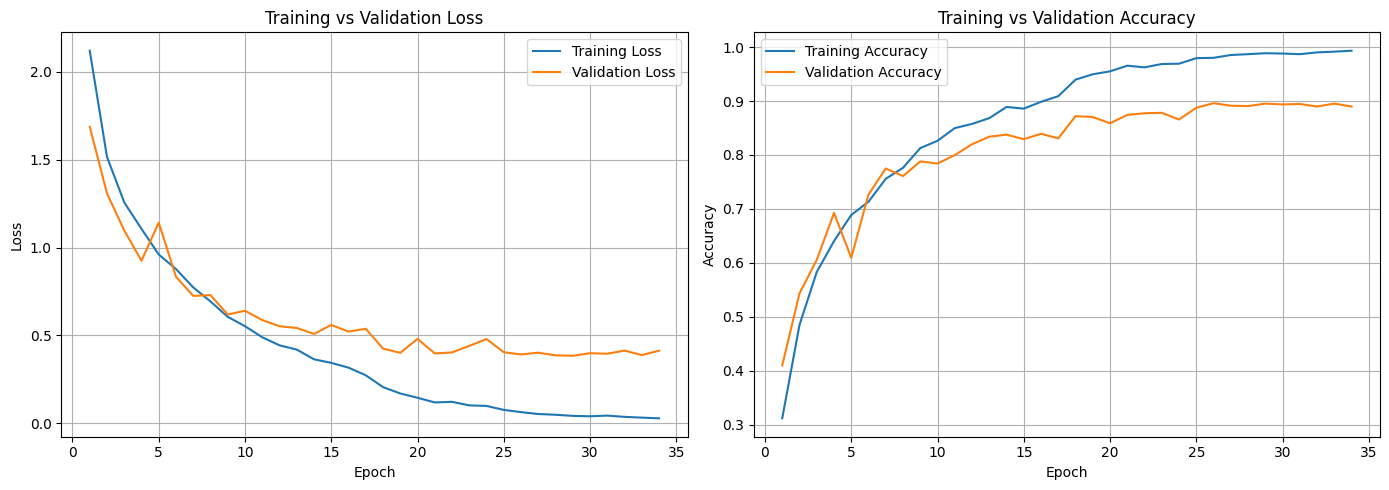

In [51]:
min_len = min(len(history.history["loss"]), len(history.history["val_loss"]))
epochs = range(1, min_len + 1)

# Plot ulang dengan data yang sudah disesuaikan
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss
ax1.plot(epochs, history.history["loss"][:min_len], label="Training Loss")
ax1.plot(epochs, history.history["val_loss"][:min_len], label="Validation Loss")
ax1.set_title("Training vs Validation Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)

# Accuracy
ax2.plot(epochs, history.history["accuracy"][:min_len], label="Training Accuracy")
ax2.plot(epochs, history.history["val_accuracy"][:min_len], label="Validation Accuracy")
ax2.set_title("Training vs Validation Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

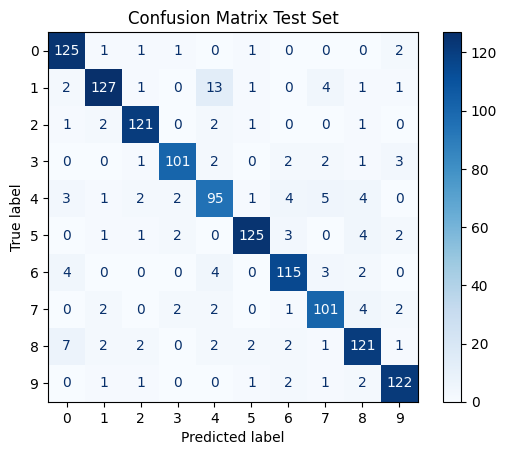


Classification Report:
              precision    recall  f1-score   support

     bobfly1       0.88      0.95      0.92       131
      ducfly       0.93      0.85      0.89       150
     brratt1       0.93      0.95      0.94       128
     barant1       0.94      0.90      0.92       112
     squcuc1       0.79      0.81      0.80       117
     greant1       0.95      0.91      0.93       138
     bubwre1       0.89      0.90      0.89       128
     oliwoo1       0.86      0.89      0.87       114
      fepowl       0.86      0.86      0.86       140
     butwoo1       0.92      0.94      0.93       130

    accuracy                           0.90      1288
   macro avg       0.89      0.90      0.89      1288
weighted avg       0.90      0.90      0.90      1288



In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Prediksi label test set
y_true = []
y_pred = []

for batch in test_tfds:
    X_batch, y_batch = batch
    preds = melspectro_model.predict(X_batch, verbose=0)
    pred_labels = np.argmax(preds, axis=1)
    
    y_true.extend(y_batch.numpy())
    y_pred.extend(pred_labels)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix Test Set")
plt.show()

# Classification Report
class_names = feature_ds.features["ebird_code"].names
print()
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


## **Export Model**

In [53]:
# Simpan model sebagai SavedModel
melspectro_model.save("BirdSet_Model.h5")

# **Inference**

In [68]:
model = models.load_model("BirdSet_Model.h5", compile=False)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 40, 157, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 40, 157, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 20, 78, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 20, 78, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 20, 78, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 39, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 10, 39, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 10, 39, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 5, 19, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 5, 19, 128)          │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 5, 19, 128)          │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 2, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64)                  │             2

 Total params: 850,122 (3.24 MB)

 Trainable params: 848,778 (3.24 MB)

 Non-trainable params: 1,344 (5.25 KB)

In [97]:
def denoise_audio(audio_array, sampling_rate):
    return nr.reduce_noise(y=audio_array, sr=sampling_rate)

def pad_or_trim(audio_array, sampling_rate, max_len):
    desired_len = int(max_len * sampling_rate)
    if len(audio_array) < desired_len:
        audio_array = np.pad(audio_array, (0, desired_len - len(audio_array)))
    else:
        audio_array = audio_array[:desired_len]
        
    return audio_array

def to_melspectrogram(audio_array, sampling_rate=16_000, n_mels=40):
    mel_spec = librosa.feature.melspectrogram(y=audio_array, sr=sampling_rate, n_mels=n_mels)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    mel_spec_db = mel_spec_db.astype(np.float32)
    mel_spec_db = mel_spec_db[..., np.newaxis]
    
    return mel_spec_db

def preprocess_mp3(file_path, sampling_rate=16_000, max_len=5):
    audio_array, sampling_rate = librosa.load(file_path, sr=sampling_rate)
    audio_array = denoise_audio(audio_array, sampling_rate)
    audio_array = pad_or_trim(audio_array, sampling_rate, max_len)

    mel_spec_db = to_melspectrogram(audio_array)

    return mel_spec_db, sampling_rate

In [111]:
def inference(file_path, class_names):
    mel_spec_db, _ = preprocess_mp3(file_path)
    mel_spec_resized = tf.image.resize(mel_spec_db, model.input_shape[1:3]).numpy()
    mel_spec_resized = np.expand_dims(mel_spec_resized, axis=0)

    pred = model.predict(mel_spec_resized)
    pred_label = np.argmax(pred)
    confidence = np.max(pred)

    return class_names[pred_label], confidence

In [55]:
!curl -L -o squirrel_cuckoo.mp3 "https://drive.google.com/uc?export=download&id=10vMTiDlS8M3lsjtAsZw2vBbfAsNd3EM_"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  573k  100  573k    0     0   195k      0  0:00:02  0:00:02 --:--:--  381k


In [64]:
audio_array, sampling_rate = librosa.load("squirrel_cuckoo.mp3", sr=16_000)
audio_array, sampling_rate

(array([ 2.4812152e-11,  2.6217606e-10, -7.4585671e-11, ...,
         2.7257633e-05,  1.4487445e-05,  3.2315296e-05], dtype=float32),
 16000)

In [65]:
ipd.Audio(audio_array, rate=16_000)

In [112]:
class_names = [
    "bobfly1", "ducfly", "brratt1", "barant1", "squcuc1", 
    "greant1", "bubwre1", "oliwoo1", "fepowl", "butwoo1"
]

inference("squirrel_cuckoo.mp3", class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


('squcuc1', 0.9999858)

In [116]:
!curl -L -o "Bright-rumped Attila.mp3" "https://drive.google.com/uc?export=download&id=1gcyh_jMgu-6jIYfx4qN7PfbaTmDbRPnd"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2571k  100 2571k    0     0   703k      0  0:00:03  0:00:03 --:--:-- 1034k


In [117]:
audio_array, sampling_rate = librosa.load("Bright-rumped Attila.mp3", sr=16_000)
audio_array, sampling_rate

(array([ 1.4365922e-08,  2.8887385e-08,  2.6097048e-08, ...,
         6.3207295e-08, -1.0722578e-08, -7.9886986e-09], dtype=float32),
 16000)

In [118]:
ipd.Audio(audio_array, rate=16_000)

In [119]:
class_names = [
    "bobfly1", "ducfly", "brratt1", "barant1", "squcuc1", 
    "greant1", "bubwre1", "oliwoo1", "fepowl", "butwoo1"
]

inference("Bright-rumped Attila.mp3", class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


('brratt1', 0.99425876)